In [13]:
# Core libraries
import os
import pandas as pd
import numpy as np
import pickle
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# Scikit-learn & Imbalanced-learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    recall_score,
    average_precision_score,
    confusion_matrix
)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [14]:
print("Step 1: Loading and Combining Data...")

# Define paths to the unzipped data folders
TRAINING_A_PATH = 'training_setA'
TRAINING_B_PATH = 'training_setB'

training_a_files = sorted(os.listdir(TRAINING_A_PATH))
training_b_files = sorted(os.listdir(TRAINING_B_PATH))

print(f"Found {len(training_a_files)} files in Set A and {len(training_b_files)} files in Set B.")

# Combine all .psv files into a single file
COMBINED_DATA_FILE = "sepsis_data.psv"
with open(COMBINED_DATA_FILE, "wb") as fout:
    # First file with header
    with open(os.path.join(TRAINING_A_PATH, training_a_files[0]), "rb") as f:
        fout.write(f.read())
    # Rest of files in Set A (without header)
    for csv_file in training_a_files[1:]:
        with open(os.path.join(TRAINING_A_PATH, csv_file), "rb") as f:
            next(f)  # Skip header
            fout.write(f.read())
    # All files in Set B (without header)
    for csv_file in training_b_files:
        with open(os.path.join(TRAINING_B_PATH, csv_file), "rb") as f:
            next(f)  # Skip header
            fout.write(f.read())

print(f"All data combined into '{COMBINED_DATA_FILE}'.")

Step 1: Loading and Combining Data...
Found 20336 files in Set A and 20000 files in Set B.
All data combined into 'sepsis_data.psv'.


Step 2: Performing Exploratory Data Analysis (EDA)...
DataFrame columns: Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')
First 5 rows of the loaded data:
      HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  \
0    NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN  ...   
1   97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN  ...   
2   89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN  ...   
3   90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN  ...  

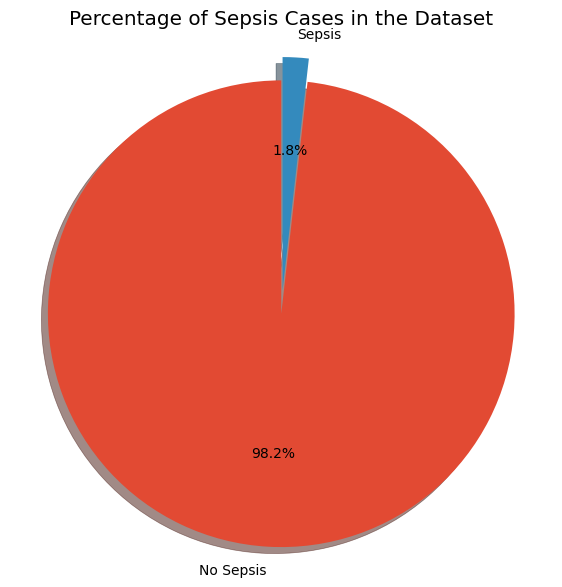

In [15]:
print("Step 2: Performing Exploratory Data Analysis (EDA)...")

# Read the combined .psv file, specifying the pipe separator
data = pd.read_csv(COMBINED_DATA_FILE, sep='|')

# --- Debugging Tip: It's always a good idea to check the columns and first few rows after loading ---
print("DataFrame columns:", data.columns)
print("First 5 rows of the loaded data:")
print(data.head())
# --- End of Tip ---

# Check Sepsis vs. No-Sepsis distribution
sepsis_counts = data['SepsisLabel'].value_counts()
no_sepsis_percent = (sepsis_counts[0] / sepsis_counts.sum()) * 100
sepsis_percent = 100 - no_sepsis_percent

print(f"\nNo Sepsis: {sepsis_counts[0]} records ({no_sepsis_percent:.2f}%)")
print(f"Sepsis: {sepsis_counts[1]} records ({sepsis_percent:.2f}%)")

# Plotting the distribution
labels = 'No Sepsis', 'Sepsis'
sizes = [no_sepsis_percent, sepsis_percent]
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Percentage of Sepsis Cases in the Dataset')
plt.show()

Percentage of missing values per feature:
Bilirubin_direct    99.807371
Fibrinogen          99.340167
TroponinI           99.047745
Bilirubin_total     98.509158
Alkalinephos        98.393194
AST                 98.377604
Lactate             97.329872
PTT                 97.055875
SaO2                96.549372
EtCO2               96.286843
Phosphate           95.986303
HCO3                95.810618
Chloride            95.460279
BaseExcess          94.579020
PaCO2               94.440121
Calcium             94.116067
Platelets           94.059502
Creatinine          93.904433
Magnesium           93.689578
WBC                 93.593199
BUN                 93.134434
pH                  93.069688
Hgb                 92.617558
FiO2                91.665754
Hct                 91.145979
Potassium           90.689082
Glucose             82.894325
Temp                66.162697
Unit2               39.425078
Unit1               39.425078
DBP                 31.345887
Resp                15.35455

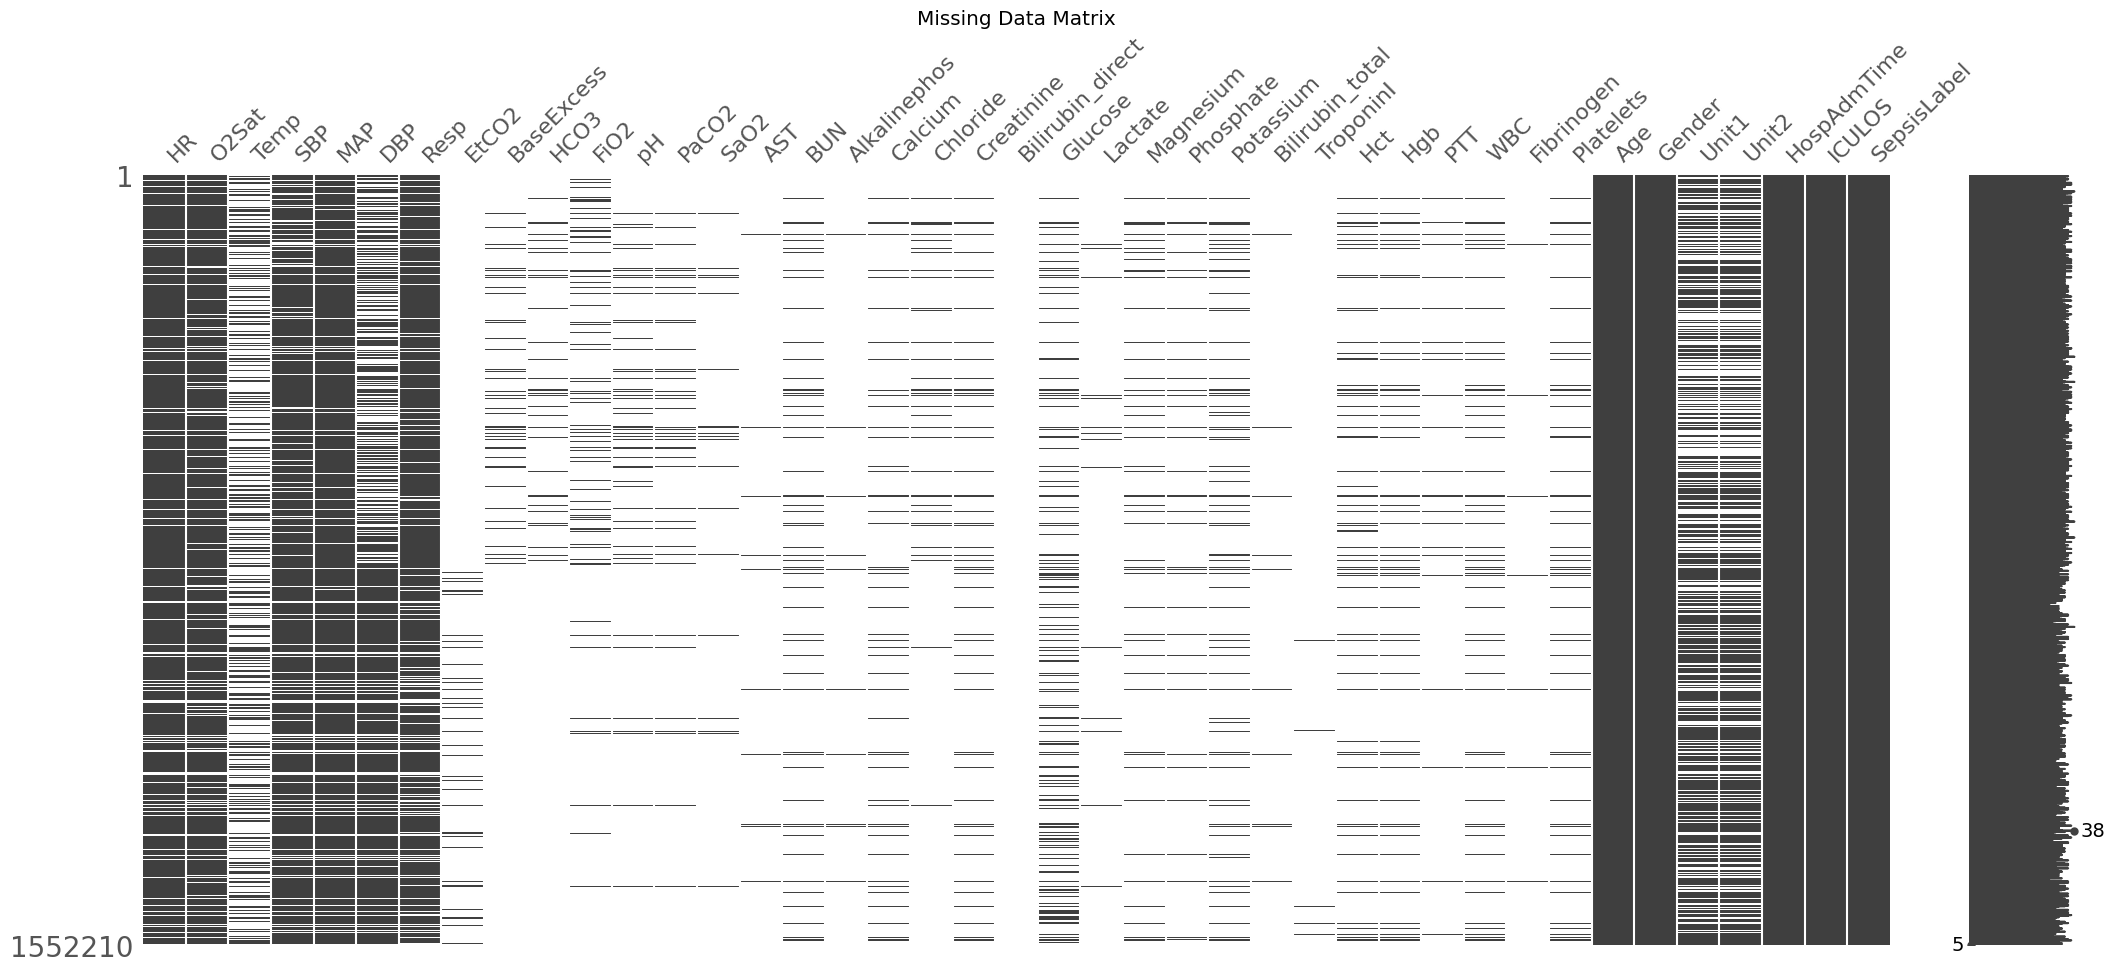

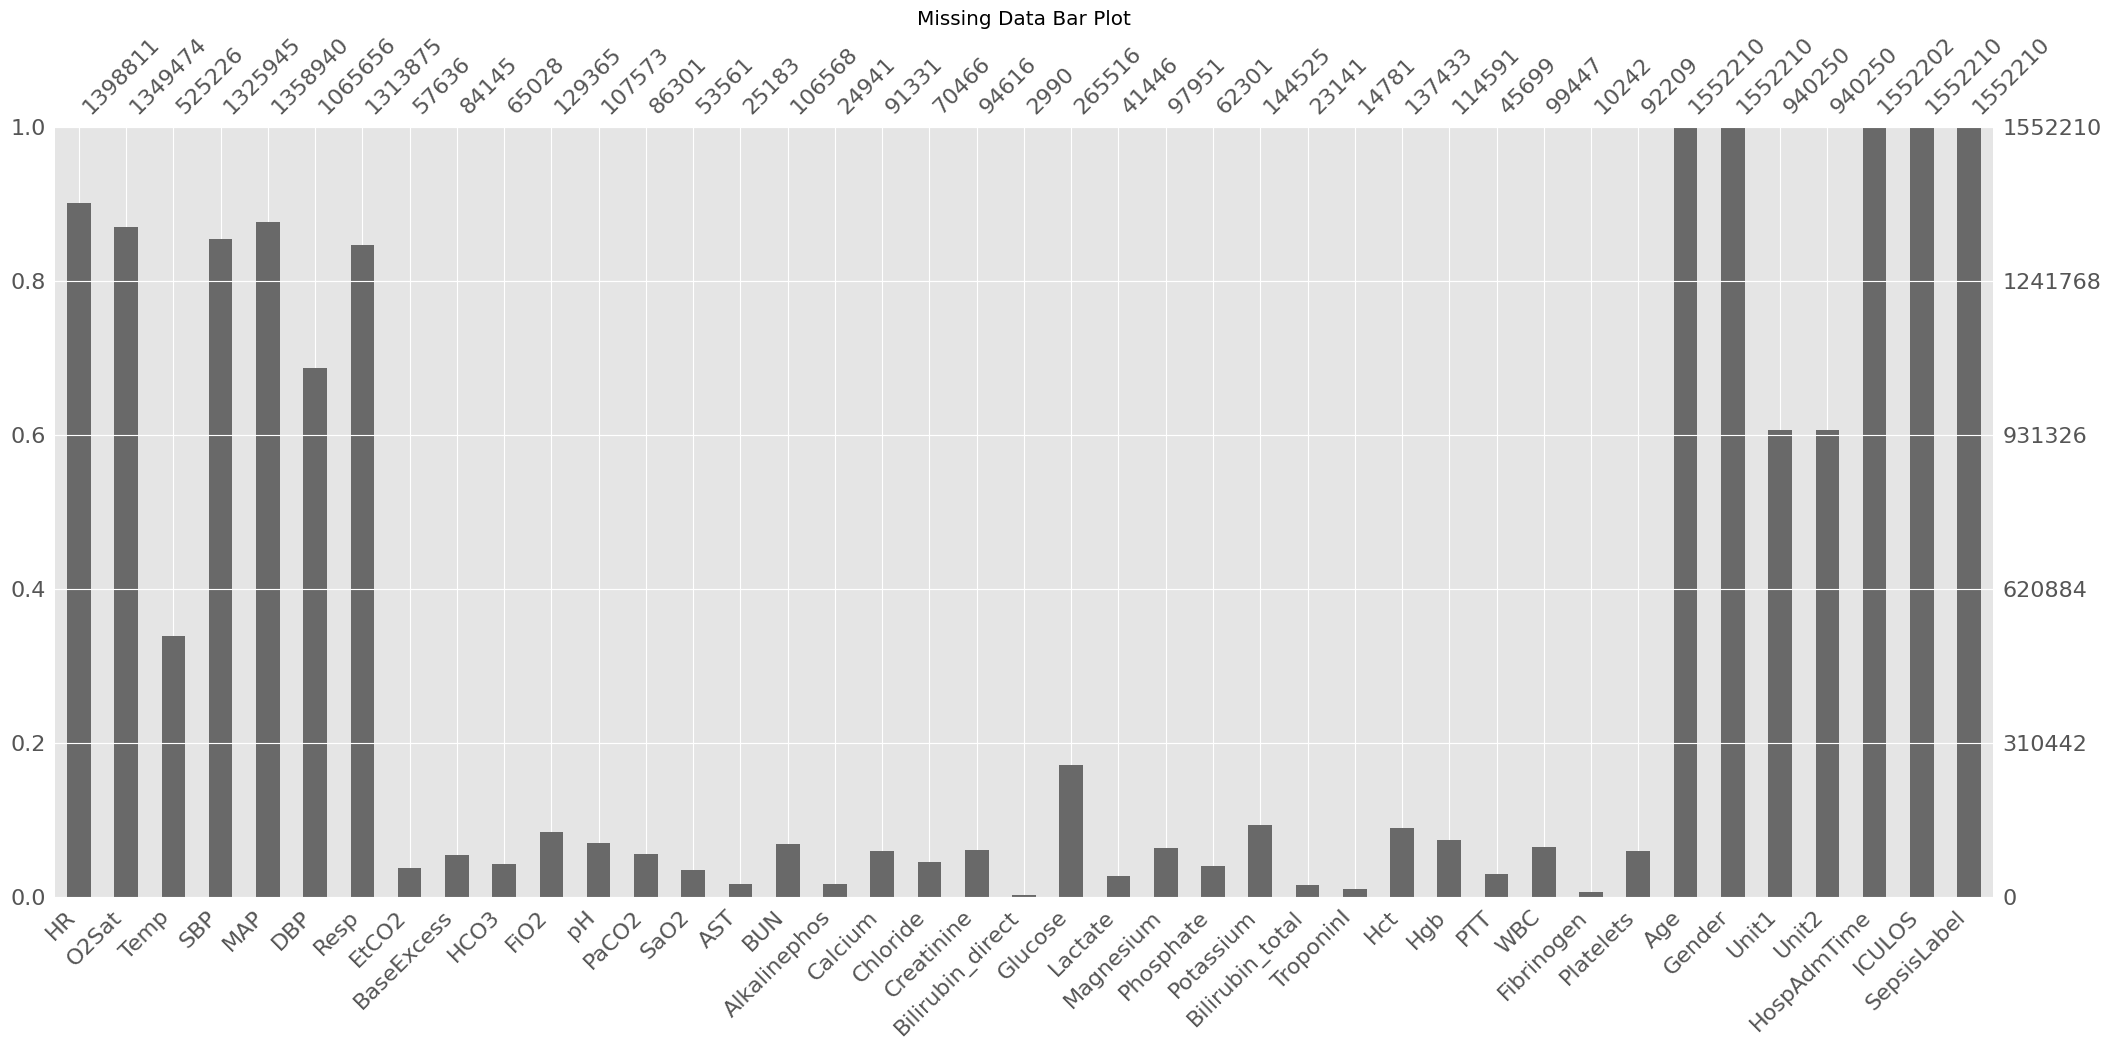

In [16]:
# Analyze and visualize missing data
print("Percentage of missing values per feature:")
missing_percent = (data.isnull().sum() / data.shape[0]) * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

msno.matrix(data)
plt.title('Missing Data Matrix')
plt.show()

msno.bar(data)
plt.title('Missing Data Bar Plot')
plt.show()

Plotting correlation matrix...


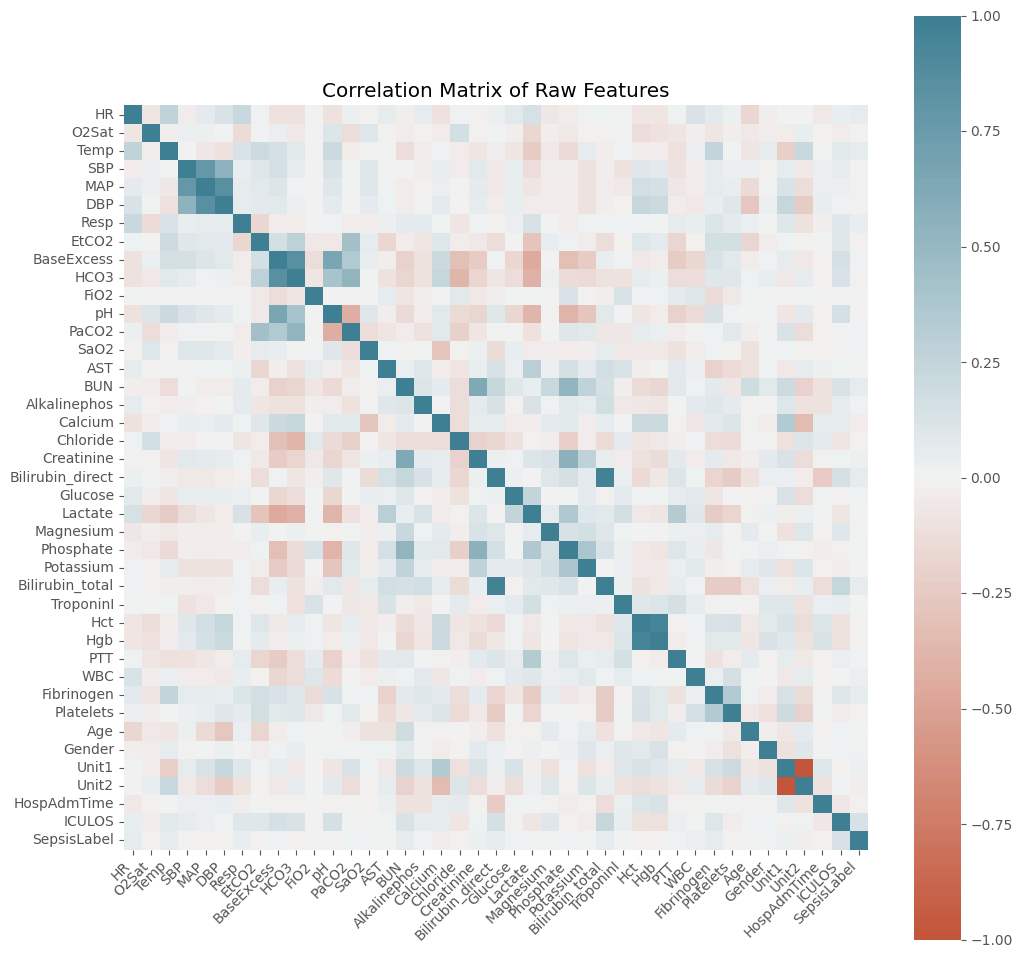

In [17]:
# Correlation matrix of original numerical data
print("Plotting correlation matrix...")
fig = plt.figure(figsize=(12, 12))
corr = data.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Raw Features')
plt.show()

In [18]:
print("Step 3: Initial Feature Selection and Preprocessing...")

# Drop features with more than 92% missing values
cols_to_keep = list(missing_percent[missing_percent < 92].index)
new_data = data[cols_to_keep]
print(f"Data shape after dropping features with >92% missing values: {new_data.shape}")

# Drop rows where 'HospAdmTime' is missing, as it's a key anchor
new_data = new_data.dropna(subset=['HospAdmTime'])
print(f"Data shape after dropping rows with missing HospAdmTime: {new_data.shape}")

Step 3: Initial Feature Selection and Preprocessing...
Data shape after dropping features with >92% missing values: (1552210, 18)
Data shape after dropping rows with missing HospAdmTime: (1552202, 18)


In [19]:
print("Step 4: Defining Feature Engineering Functions...")

def fe_new_age(df):
    df.loc[df['Age'] >= 60, 'new_age'] = 'old'
    df.loc[df['Age'] < 10, 'new_age'] = 'infant'
    df.loc[(df['Age'] >= 10) & (df['Age'] < 60), 'new_age'] = 'adult'
    return df

def fe_new_hr(df):
    df.loc[(df['HR'] >= 70) & (df['HR'] < 110) & (df['Age'] < 10), 'new_hr'] = 'normal'
    df.loc[(df['HR'] > 60) & (df['HR'] < 100) & (df['Age'] >= 10), 'new_hr'] = 'normal'
    df.loc[((df['HR'] < 70) | (df['HR'] >= 110)) & (df['Age'] < 10), 'new_hr'] = 'abnormal'
    df.loc[((df['HR'] < 60) | (df['HR'] >= 100)) & (df['Age'] >= 10), 'new_hr'] = 'abnormal'
    df['new_hr'].fillna('Missing', inplace=True)
    return df

def fe_new_o2sat(df):
    df.loc[df['O2Sat'].between(95, 100), 'new_o2sat'] = 'normal'
    df.loc[df['O2Sat'] < 95, 'new_o2sat'] = 'abnormal'
    df['new_o2sat'].fillna('missing', inplace=True)
    return df

def fe_new_temp(df):
    df.loc[df['Temp'].between(36, 38), 'new_temp'] = 'normal'
    df.loc[(df['Temp'] < 36) | (df['Temp'] > 38), 'new_temp'] = 'abnormal'
    df['new_temp'].fillna('Missing', inplace=True)
    return df

def fe_new_bp(df):
    df.loc[df['SBP'].between(90, 120) & df['DBP'].between(60, 80), 'new_bp'] = 'normal'
    df.loc[df['SBP'] < 90, 'new_bp'] = 'low'
    df.loc[df['SBP'].between(120, 140) & df['DBP'].between(80, 90), 'new_bp'] = 'elevated'
    df.loc[(df['SBP'] > 140) | (df['DBP'] > 90), 'new_bp'] = 'high'
    df['new_bp'].fillna('Missing', inplace=True)
    return df

def fe_new_resp(df):
    df['new_resp'] = 'abnormal' # Default
    df.loc[df['Resp'].between(12, 20) & (df['Age'] > 18), 'new_resp'] = 'normal'
    df.loc[df['Resp'].between(12, 16) & df['Age'].between(12, 18), 'new_resp'] = 'normal'
    df.loc[df['Resp'].between(18, 30) & df['Age'].between(6, 12), 'new_resp'] = 'normal'
    df.loc[df['Resp'].between(22, 34) & df['Age'].between(3, 6), 'new_resp'] = 'normal'
    df.loc[df['Resp'].between(24, 40) & df['Age'].between(1, 3), 'new_resp'] = 'normal'
    df.loc[df['Resp'].between(30, 60) & (df['Age'] < 1), 'new_resp'] = 'normal'
    df.loc[df['Resp'].isnull(), 'new_resp'] = 'missing'
    return df

def fe_new_map(df):
    df.loc[df['MAP'].between(70, 100), 'new_map'] = 'normal'
    df.loc[(df['MAP'] < 70) | (df['MAP'] > 100), 'new_map'] = 'abnormal'
    df['new_map'].fillna('Missing', inplace=True)
    return df

def fe_new_fio2(df):
    df.loc[df['FiO2'] < 0.8, 'new_fio2'] = 'normal'
    df.loc[df['FiO2'] >= 0.8, 'new_fio2'] = 'abnormal'
    df['new_fio2'].fillna('Missing', inplace=True)
    return df

Step 4: Defining Feature Engineering Functions...


In [20]:
# Apply all feature engineering functions
new_data = fe_new_age(new_data)
new_data = fe_new_hr(new_data)
new_data = fe_new_o2sat(new_data)
new_data = fe_new_temp(new_data)
new_data = fe_new_bp(new_data)
new_data = fe_new_resp(new_data)
new_data = fe_new_map(new_data)
new_data = fe_new_fio2(new_data)

print("Feature engineering complete. Preview of new features:")
new_data[['Age', 'new_age', 'HR', 'new_hr', 'SBP', 'DBP', 'new_bp', 'SepsisLabel']].sample(10)

Feature engineering complete. Preview of new features:


,Age,new_age,HR,new_hr,SBP,DBP,new_bp,SepsisLabel
1096555,77.00,old,68.0,normal,121.0,57.0,Missing,0
166981,79.44,old,76.0,normal,126.0,NaN,Missing,0
1059041,73.00,old,90.0,normal,119.0,83.0,Missing,0
954386,60.00,old,73.0,normal,122.0,58.0,Missing,0
532305,48.47,adult,88.0,normal,NaN,NaN,Missing,0
1056144,60.00,old,93.0,normal,156.0,56.0,high,0
729175,71.60,old,101.0,abnormal,132.0,62.0,Missing,0
666126,53.78,adult,NaN,Missing,NaN,NaN,Missing,0
843702,63.00,old,83.0,normal,134.0,50.0,Missing,0
1492475,64.00,old,NaN,Missing,NaN,NaN,Missing,0


In [21]:
print("Step 5: Encoding Data and Final Preparation...")

# Select engineered and demographic features
final_feature_cols = ['Gender', 'new_age', 'new_o2sat', 'new_temp', 'new_bp', 'new_resp', 'new_map', 'new_fio2', 'new_hr', 'HospAdmTime', 'ICULOS']
target_col = ['SepsisLabel']
new_featured_data = new_data[final_feature_cols + target_col]

# One-Hot Encode categorical features
categorical_cols = ['new_age', 'new_o2sat', 'new_temp', 'new_bp', 'new_resp', 'new_map', 'new_fio2', 'new_hr']
encoded_df = pd.get_dummies(new_featured_data, columns=categorical_cols, drop_first=False)

# Manually encode Gender (0 for female, 1 for male)
encoded_df['Gender'] = encoded_df['Gender'].apply(lambda x: 1 if x == 1 else 0)

# Impute missing HospAdmTime using the median
imputer = SimpleImputer(strategy='median')
encoded_df['HospAdmTime'] = imputer.fit_transform(encoded_df[['HospAdmTime']])

# Drop redundant columns to reduce multicollinearity
cols_to_drop = [col for col in encoded_df.columns if 'Missing' in col or 'missing' in col]
cols_to_drop.append('new_age_adult') # Example of dropping one category for multicollinearity
final_df = encoded_df.drop(columns=cols_to_drop)

print("Final processed data shape:", final_df.shape)
final_df.head()

Step 5: Encoding Data and Final Preparation...
Final processed data shape: (1552202, 21)


,Gender,HospAdmTime,ICULOS,SepsisLabel,new_age_old,new_o2sat_abnormal,new_o2sat_normal,new_temp_abnormal,new_temp_normal,new_bp_elevated,...,new_bp_low,new_bp_normal,new_resp_abnormal,new_resp_normal,new_map_abnormal,new_map_normal,new_fio2_abnormal,new_fio2_normal,new_hr_abnormal,new_hr_normal
0,0,-0.03,1,0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,-0.03,2,0,True,False,True,False,False,False,...,False,False,False,True,False,True,False,False,False,True
2,0,-0.03,3,0,True,False,True,False,False,False,...,False,False,True,False,False,True,False,False,False,True
3,0,-0.03,4,0,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,0,-0.03,5,0,True,True,False,False,False,False,...,False,False,True,False,False,True,False,True,True,False


Step 6: Splitting Data and Handling Imbalance...
Train set shape: (1164151, 20), Test set shape: (388051, 20)
Class distribution in training set (before SMOTE):
SepsisLabel
0    0.982015
1    0.017985
Name: proportion, dtype: float64

Class distribution in training set (after SMOTE):
SepsisLabel
0    0.5
1    0.5
Name: proportion, dtype: float64


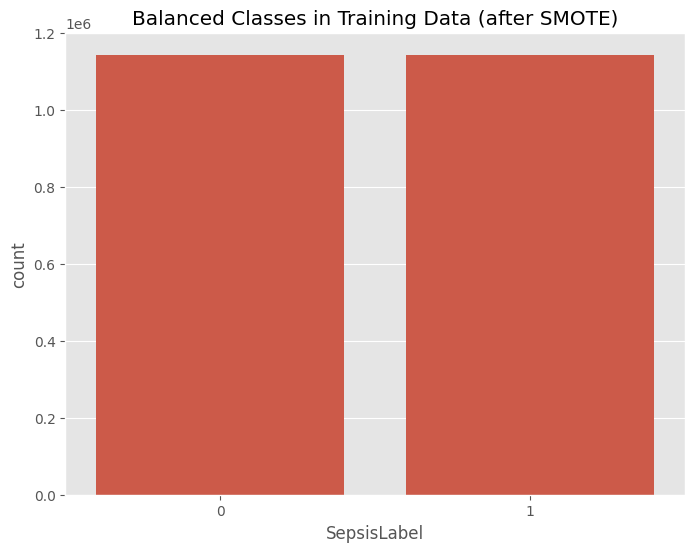

In [22]:
print("Step 6: Splitting Data and Handling Imbalance...")

# Define features (X) and target (y)
X = final_df.drop('SepsisLabel', axis=1)
y = final_df['SepsisLabel']

# Split data into training and testing sets, stratifying by the target label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y
)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Class distribution in training set (before SMOTE):")
print(y_train.value_counts(normalize=True))

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nClass distribution in training set (after SMOTE):")
print(y_train_res.value_counts(normalize=True))

# Plot the balanced classes
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res)
plt.title('Balanced Classes in Training Data (after SMOTE)')
plt.show()

Training and evaluating models...

--- Logistic Regression ---
Confusion Matrix:
[[297908  83164]
 [  3244   3735]]


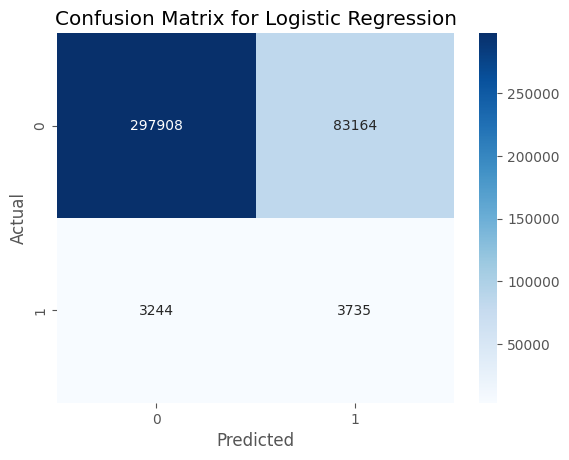


--- K-Nearest Neighbors ---
Confusion Matrix:
[[361457  19615]
 [  4104   2875]]


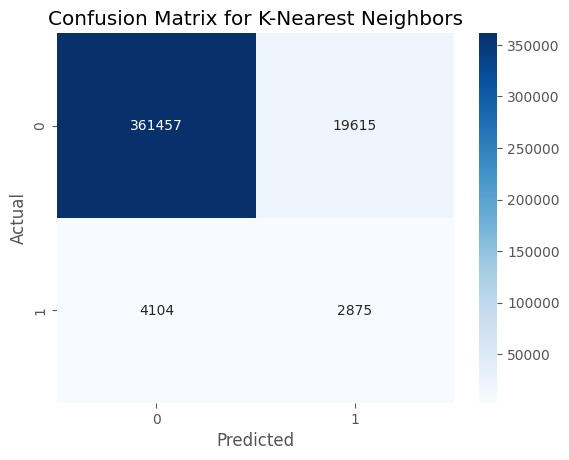


--- Decision Tree ---
Confusion Matrix:
[[366617  14455]
 [  4893   2086]]


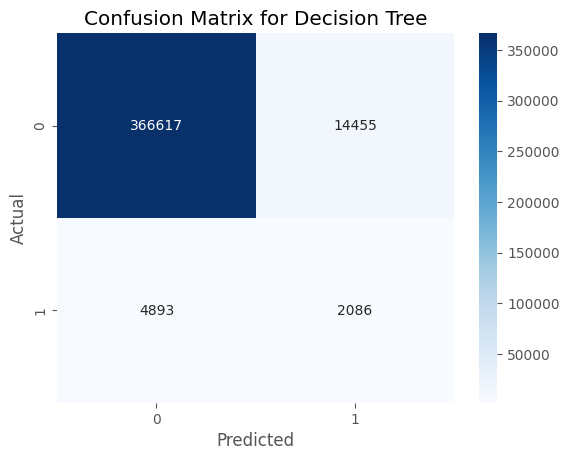


--- Gaussian Naive Bayes ---
Confusion Matrix:
[[315685  65387]
 [  3870   3109]]


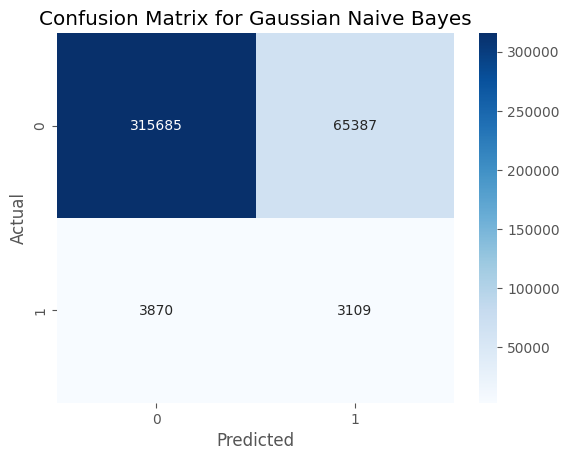

In [23]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Gaussian Naive Bayes": GaussianNB()
}

results_list = []

def score_model(model_name, y_true, y_pred):
    """Calculates and returns a dictionary of performance metrics."""
    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'avg_precision': average_precision_score(y_true, y_pred)
    }

print("Training and evaluating models...")
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    model_scores = score_model(name, y_test, y_pred)
    results_list.append(model_scores)
    
    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

--- Model Comparison ---
                  model  accuracy  precision    recall  avg_precision
0   Logistic Regression  0.777328   0.042981  0.535177       0.031362
1   K-Nearest Neighbors  0.938877   0.127835  0.411950       0.063237
2         Decision Tree  0.950141   0.126111  0.298897       0.050303
3  Gaussian Naive Bayes  0.821526   0.045390  0.445479       0.030193


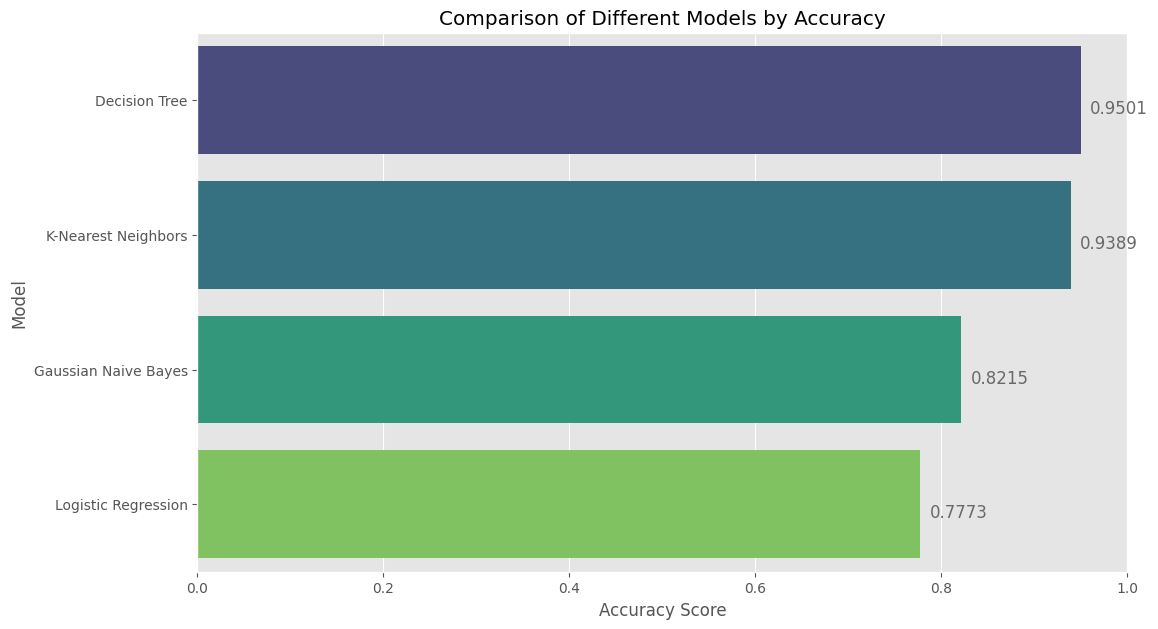

In [24]:
results_df = pd.DataFrame(results_list)
print("--- Model Comparison ---")
print(results_df)

# Plot comparison of model accuracies
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='accuracy', y='model', data=results_df.sort_values('accuracy', ascending=False), palette='viridis')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Comparison of Different Models by Accuracy')
plt.xlim(0, 1.0)
# Add text labels
for i in ax.patches:
    ax.text(i.get_width() + .01, i.get_y() + .5, str(round(i.get_width(), 4)),
            fontsize=12, color='dimgrey')
plt.show()

In [ ]:
print("Step 7: Saving the Best Model...")

# Based on the results, the Decision Tree is the best.
best_model_name = "Decision Tree"
best_model = models[best_model_name]

filename = 'best_model_dtree.sav'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best performing model ('{best_model_name}') saved to '{filename}'.")

# Example of how to load and use it later
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(f"Loaded model accuracy: {result}")

Step 7: Saving the Best Model...
Best performing model ('Decision Tree') saved to 'best_model_dtree.sav'.
